In [1]:
import os
import pandas as pd
import random

# sklearn
from sklearn.model_selection import train_test_split

# Pytorch
import torch
import torch.nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset

# OpenCV
import cv2

# plotting
import matplotlib.pyplot as plt
import json


# Let's Visualise random images and mask of that image from the dataset

In [2]:
train_df = pd.read_csv("/Users/akhil/Documents/Machine learning/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt", header =None, names =["train"])
trainval_df = pd.read_csv("/Users/akhil/Documents/Machine learning/VOCdevkit/VOC2012/ImageSets/Segmentation/trainval.txt", header =None, names =["train_val"])
test_df = pd.read_csv("/Users/akhil/Documents/Machine learning/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt", header =None, names =["val"])

In [3]:
train_df.shape, trainval_df.shape, test_df.shape

((1464, 1), (2913, 1), (1449, 1))

In [4]:
jpeg_images = "/Users/akhil/Documents/Machine learning/VOCdevkit/VOC2012/JPEGImages/"

In [5]:
images = []
for file in os.listdir(jpeg_images):
    images.append(file)

images

['2008_008336.jpg',
 '2007_000904.jpg',
 '2012_000760.jpg',
 '2009_004164.jpg',
 '2008_005612.jpg',
 '2009_002515.jpg',
 '2008_003263.jpg',
 '2012_002177.jpg',
 '2012_002611.jpg',
 '2009_002273.jpg',
 '2008_005174.jpg',
 '2009_000464.jpg',
 '2008_001312.jpg',
 '2008_008450.jpg',
 '2012_001318.jpg',
 '2011_004905.jpg',
 '2008_001306.jpg',
 '2008_008444.jpg',
 '2008_007777.jpg',
 '2011_004911.jpg',
 '2008_003511.jpg',
 '2009_002267.jpg',
 '2012_004274.jpg',
 '2008_005160.jpg',
 '2009_004616.jpg',
 '2009_004170.jpg',
 '2008_002169.jpg',
 '2010_000879.jpg',
 '2008_003277.jpg',
 '2012_002163.jpg',
 '2008_004518.jpg',
 '2008_008322.jpg',
 '2010_005901.jpg',
 '2008_007011.jpg',
 '2009_001008.jpg',
 '2008_001460.jpg',
 '2009_000316.jpg',
 '2012_003255.jpg',
 '2009_003637.jpg',
 '2010_000689.jpg',
 '2009_005246.jpg',
 '2008_007039.jpg',
 '2010_005929.jpg',
 '2010_003380.jpg',
 '2012_000984.jpg',
 '2008_000756.jpg',
 '2008_001448.jpg',
 '2008_006327.jpg',
 '2008_006441.jpg',
 '2008_007987.jpg',


In [6]:
# split the larger trainval into train and val set
train_df, val_df = train_test_split(trainval_df, train_size=0.65, test_size=0.35, random_state=42, shuffle=True)

# rename the columns of the train and val df
train_df.rename(columns = {"train_val": "train"}, inplace=True)
val_df.rename(columns = {"train_val": "val"}, inplace=True)

# reset the index of the train and val df
train_df.reset_index(drop=True, inplace = True)
val_df.reset_index(drop=True, inplace = True)


In [7]:
train_df.shape, val_df.shape

((1893, 1), (1020, 1))

In [8]:
train_df.head()

,train
0,2011_001607
1,2010_004805
2,2008_002495
3,2010_004620
4,2008_005544


In [9]:
img = cv2.imread(f"/Users/akhil/Documents/Machine learning/VOCdevkit/VOC2012/JPEGImages/2011_001607.jpg")
img.shape

(500, 333, 3)

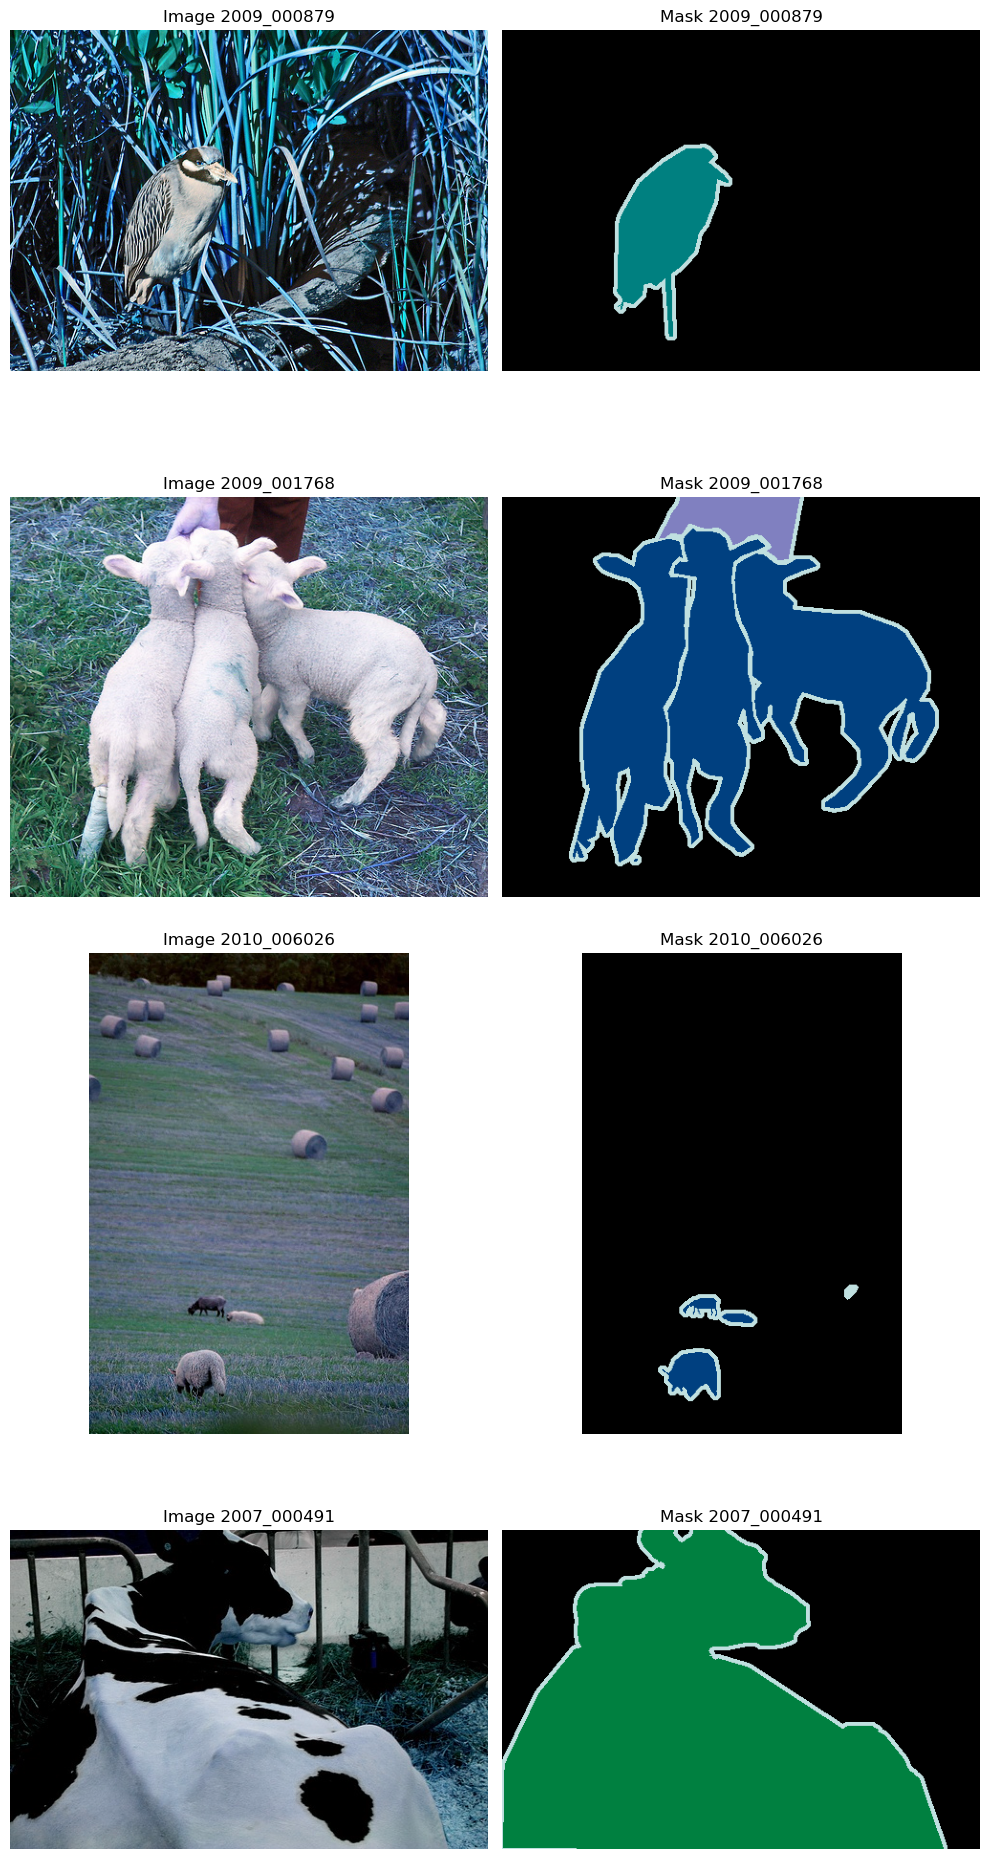

In [12]:
# generate any 4 random image indexes from train_df
random_indexes = torch.randint(0, len(train_df), size = (4,))

# let's plot 4 images and their respective masks
fig, axs = plt.subplots(4,2, figsize=(10, 20))
for idx, element in enumerate(random_indexes):
    image_number = train_df.iloc[element.item()]["train"]
    
    img = cv2.imread(f"/Users/akhil/Documents/Machine learning/VOCdevkit/VOC2012/JPEGImages/{image_number}.jpg")
    mask = cv2.imread(f"/Users/akhil/Documents/Machine learning/VOCdevkit/VOC2012/SegmentationClass/{image_number}.png")

    
    axs[idx, 0].imshow(img)
    axs[idx, 0].set_title(f'Image {image_number}')
    axs[idx, 0].axis('off')

    axs[idx, 1].imshow(mask)
    axs[idx, 1].set_title(f'Mask {image_number}')
    axs[idx, 1].axis('off')


plt.tight_layout()

# Show the plot
plt.show()

    
    

# Let's build a custom dataset class to read the data


In [13]:
train_df.shape, val_df.shape


((1893, 1), (1020, 1))

In [14]:
class PascalDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.root = "/Users/akhil/Documents/Machine learning/VOCdevkit/VOC2012/"
        self.image_dir = "/Users/akhil/Documents/Machine learning/VOCdevkit/VOC2012/JPEGImages/"
        self.mask_dir = "/Users/akhil/Documents/Machine learning/VOCdevkit/VOC2012/SegmentationClass/"
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir, self.df.iloc[idx, 0] + '.jpg')
        mask_name = os.path.join(self.mask_dir, self.df.iloc[idx, 0] + '.png')
        
        image = cv2.imread(img_name)
        mask = cv2.imread(mask_name)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


train_pascal = PascalDataset(train_df, transform=False)
val_pascal = PascalDataset(val_df, transform=False)
        

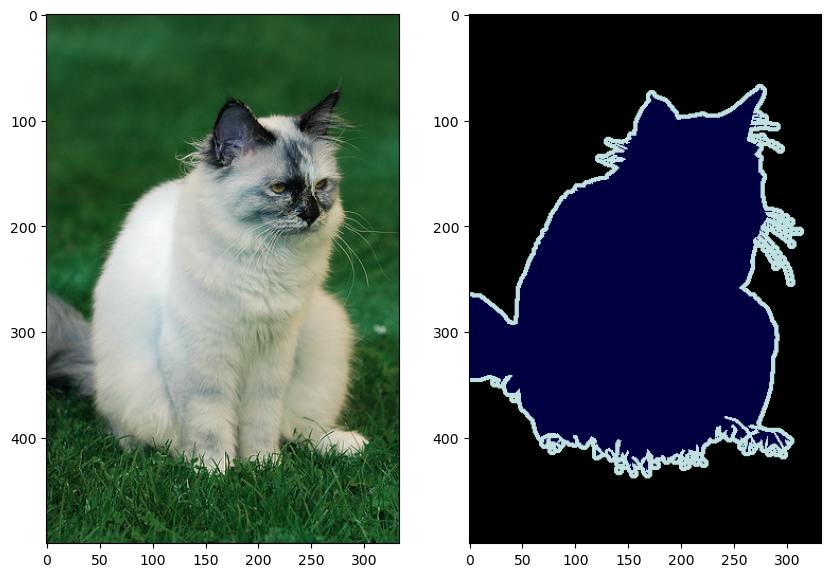

In [15]:
img, mask = train_pascal[0]
plt.figure(figsize=(10,20))

plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(mask)


# Lets load these datsets to a pytorch dataLoader

In [17]:
train_dataloader = DataLoader(train_pascal, batch_size = 8, shuffle=False, num_workers = 1)
val_dataloader = DataLoader(val_pascal, batch_size = 8, shuffle=False, num_workers = 1)

In [18]:
len(train_dataloader)

237

# Build vgg 16

In [19]:
weights = torchvision.models.VGG16_Weights.DEFAULT
model = torchvision.models.vgg16(weights=weights)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/akhil/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|████████████████████████████████████████| 528M/528M [01:26<00:00, 6.42MB/s]


In [20]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [24]:
list(model.features.children())

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1